In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import GloVe

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt

In [5]:
file_path = '../data/processed/full_2k.csv'
full_2k = pd.read_csv(file_path)

In [6]:
le = LabelEncoder()
full_2k['label'] = le.fit_transform(full_2k['Category'])
num_classes = len(le.classes_)

print(full_2k[['Category', 'label']].head())

    Category  label
0  Biography      0
1   Religion      8
2  Biography      0
3    General      3
4    History      4


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    full_2k['Description'], full_2k['label'], test_size=0.2, random_state=13)

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

full_2k['cleaned_desc'] = full_2k['Description'].apply(clean_text)

In [9]:
glove = GloVe(name='6B', dim=50)  # 50-dimensional embeddings

def sentence_to_vec(sentence, glove):
    words = sentence.split()
    vecs = [glove[word] for word in words if word in glove.stoi]  # skip unknown words
    if len(vecs) == 0:
        return torch.zeros(glove.dim)
    return torch.mean(torch.stack(vecs), dim=0)

X_vectors = torch.stack(full_2k['cleaned_desc'].apply(lambda x: sentence_to_vec(x, glove)).tolist())

In [10]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
# Convert labels to tensors
y_tensor = torch.tensor(full_2k['label'].values, dtype=torch.long)

# Split X_vectors into train/test
N_TRAIN = int(len(full_2k)*0.8)
X_train_vectors = X_vectors[:N_TRAIN]
X_test_vectors = X_vectors[N_TRAIN:]
y_train_tensor = y_tensor[:N_TRAIN]
y_test_tensor = y_tensor[N_TRAIN:]

train_dataset = TextDataset(X_train_vectors, y_train_tensor)
test_dataset = TextDataset(X_test_vectors, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [12]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [46]:
model = SimpleNN(input_dim=50, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Train Loss: 1.4265, Val Loss: 0.9621
Epoch 2/50, Train Loss: 1.0918, Val Loss: 0.8781
Epoch 3/50, Train Loss: 1.0358, Val Loss: 0.8490
Epoch 4/50, Train Loss: 1.0037, Val Loss: 0.8306
Epoch 5/50, Train Loss: 0.9808, Val Loss: 0.8012
Epoch 6/50, Train Loss: 0.9654, Val Loss: 0.7907
Epoch 7/50, Train Loss: 0.9520, Val Loss: 0.7739
Epoch 8/50, Train Loss: 0.9407, Val Loss: 0.7745
Epoch 9/50, Train Loss: 0.9298, Val Loss: 0.7688
Epoch 10/50, Train Loss: 0.9213, Val Loss: 0.7599
Epoch 11/50, Train Loss: 0.9135, Val Loss: 0.7511
Epoch 12/50, Train Loss: 0.9066, Val Loss: 0.7545
Epoch 13/50, Train Loss: 0.8999, Val Loss: 0.7418
Epoch 14/50, Train Loss: 0.8942, Val Loss: 0.7452
Epoch 15/50, Train Loss: 0.8887, Val Loss: 0.7582
Epoch 16/50, Train Loss: 0.8830, Val Loss: 0.7378
Epoch 17/50, Train Loss: 0.8788, Val Loss: 0.7308
Epoch 18/50, Train Loss: 0.8728, Val Loss: 0.7215
Epoch 19/50, Train Loss: 0.8691, Val Loss: 0.7314
Epoch 20/50, Train Loss: 0.8639, Val Loss: 0.7154
Epoch 21/

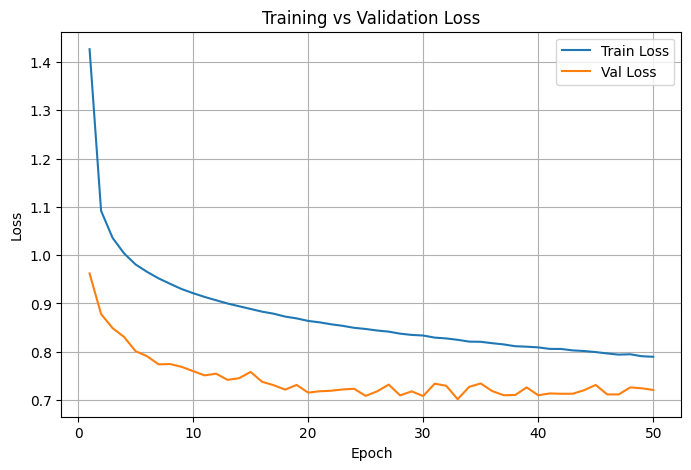

In [47]:
epochs = 50
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # ---- Training ----
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimiser.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

# ---- Plot losses ----
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_loss_history, label="Train Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [48]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.7617


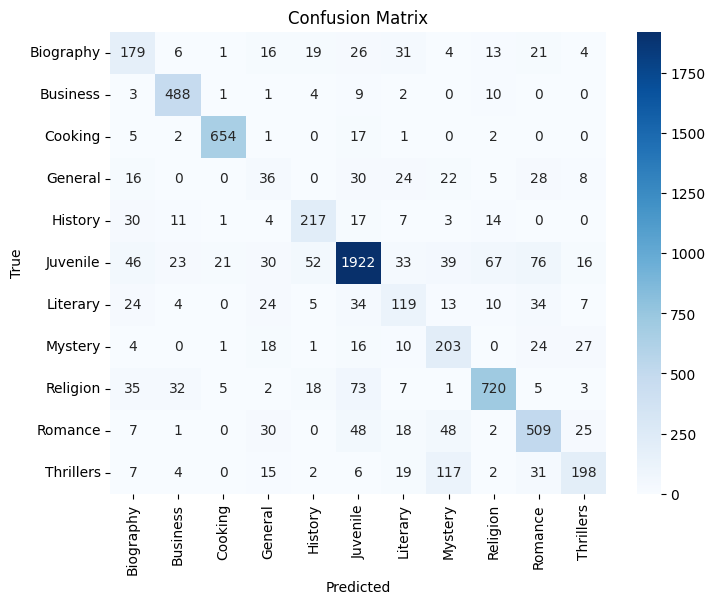

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
